1. Load required packages

In [99]:
from IPython.display import Image
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly_calplot import calplot
%matplotlib inline

import time
import random
import calmap
import warnings
warnings.filterwarnings('ignore')


sns.set_theme(style="darkgrid")
current_palette = sns.color_palette()


#from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

#import graphviz

#os.environ["PATH"] += os.pathsep + 'D:/Programs/Graphviz/bin'


In [65]:
pd.options.display.min_rows = 20
pd.options.display.max_columns = 500


Machine Learning Process

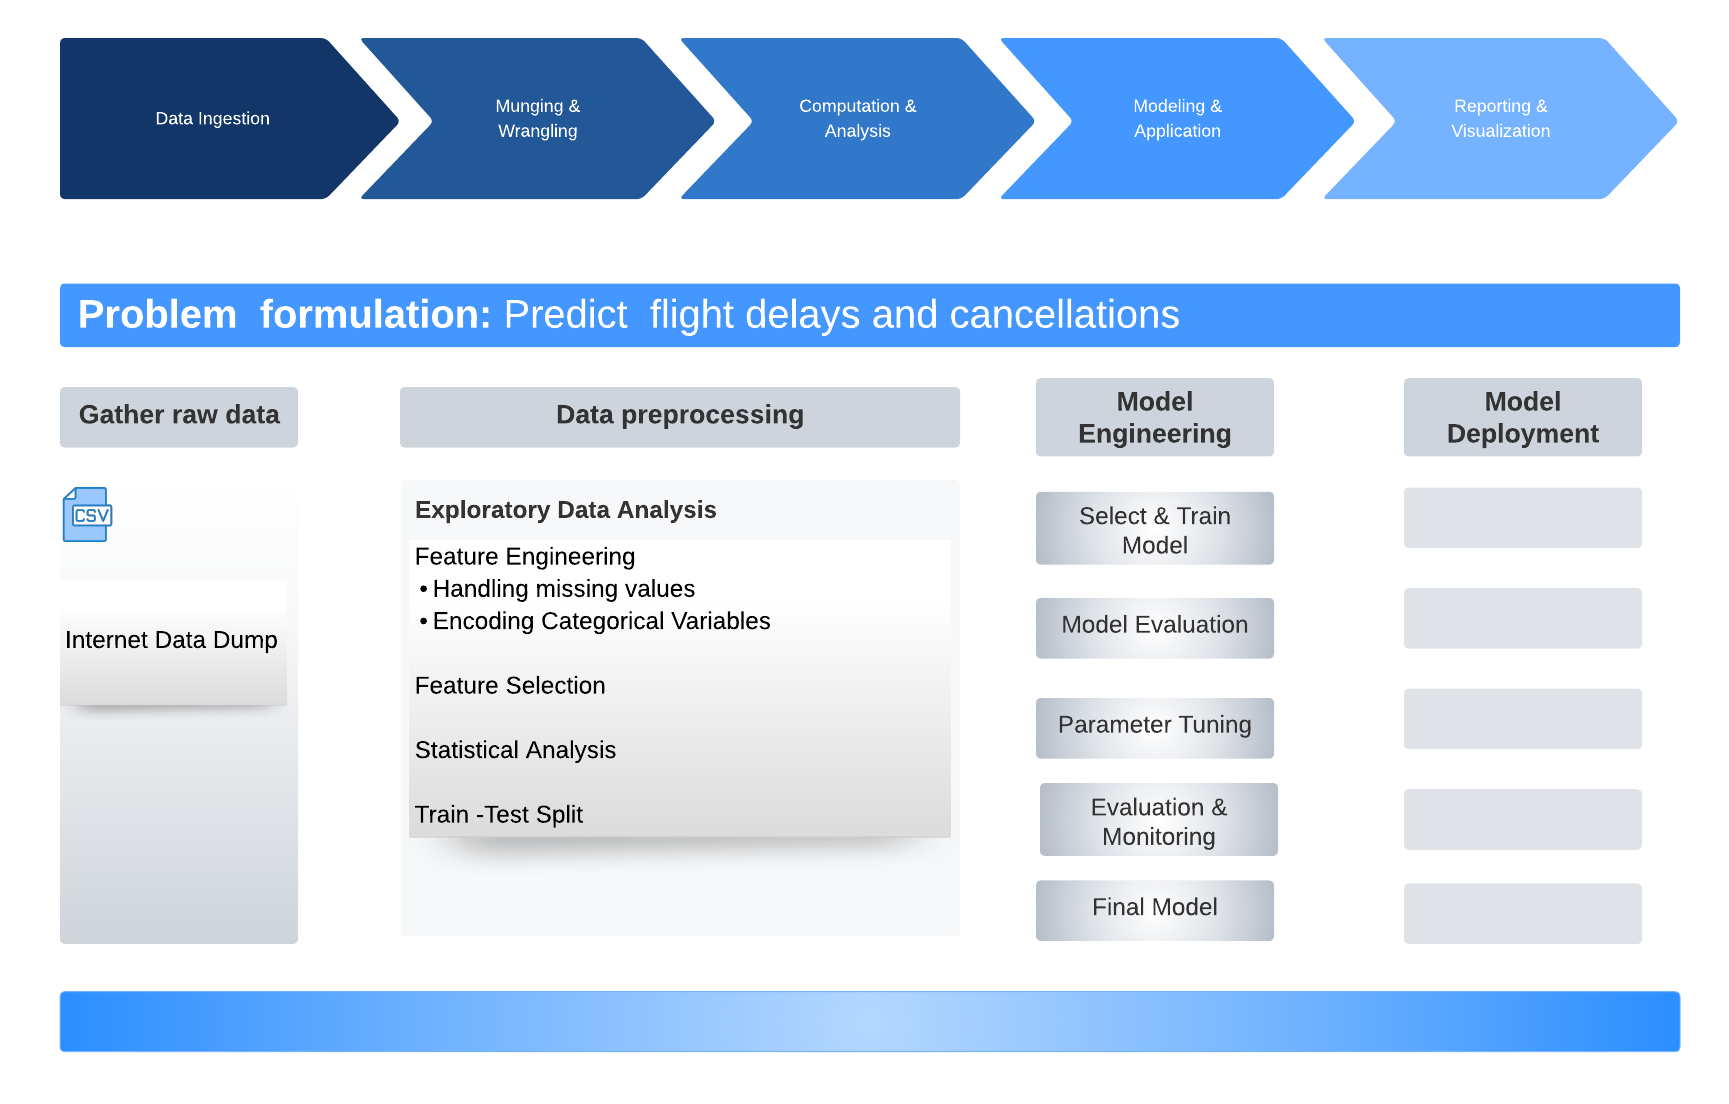

In [66]:
Image("../../data/images/MLProcess.png")

### Load in the data

In [67]:
n= 40000000
s= 1000000
skip = sorted(random.sample(range(1,n),n-s))
df_flights = pd.read_csv("../../data/eda/flights/all_flight_data_20182019_20212022/all_flight_data_20182022NC.zip",skiprows=skip, low_memory=False)


In [68]:
df_flights = df_flights.rename(columns={"Operating_Airline ": "Operating_Airline", "Flight_Number_Operating_Airline": "Flight_Number"})

In [69]:
airlines = pd.read_csv(
    "../../data/databases/flight_attributes/airlines.csv.zip", low_memory=False)
airline_mapper = airlines.set_index("Code")["Description"]

In [70]:
cancellation_codes = pd.read_csv(
    "../../data/databases/flight_attributes/cancellation_codes.csv", low_memory=False)
cancellation_code_mapper = cancellation_codes.set_index(
    "CANCELLATION_REASON")["CANCELLATION_DESCRIPTION"]


In [71]:
usa_airports = (pd.read_csv("../../data/databases/flight_attributes/usa_airports.csv.zip",
                            usecols= ["iata","latitude","longitude"], 
                            low_memory=False))
usa_airports = usa_airports.rename(columns={"iata": "Origin"})



### Data Pre-processing Phase
- EDA
- Feature Engineering
  - Handling missing values
  - Encoding Categorical Variables
  - Feature creation
- Feature Selection 
- Statistical Analysis
- Train - Test Split

In [72]:
#df_flights.dtypes

In [73]:
def airline_mapping(df_flights):
    df_flights["Operating_Airline"] = (
        df_flights["Operating_Airline"].map(airline_mapper))
    df_flights["CancellationCode"] = (
        df_flights["CancellationCode"].map(cancellation_code_mapper))
    return df_flights

##########Flight Status Categories####################
###############DepDelayGroups#########################
# Departure Delay intervals until 180 mins
def DepDelay_Class(df_flights):
    df_flights["DepDelayClass"] = None
    df_flights.loc[df_flights["DepDelayMinutes"] <= 15, "DepDelayClass"] = "OnTime"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 15) & (df_flights["DepDelayMinutes"] <= 45), "DepDelayClass"] = "Delay15_45"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 45), "DepDelayClass"] = "Delay45_180"
    df_flights.loc[(df_flights["Cancelled"] > 0), "DepDelayClass"] = "Cancelled"
    return df_flights

def tweak_df_flights(df_flights):
    DepDelay_Class(df_flights)
    SELECTED_COLUMNS = ["FlightDate", "Operating_Airline", "Tail_Number", "Flight_Number", "OriginAirportID",
                        "Origin", "OriginCityName", "OriginState", "OriginStateName", "DestAirportID", "Dest", "DestCityName",
                        "DestState", "DestStateName", "CRSDepTime", "DepTime", "DepDelay", "DepDel15", "DepDelayMinutes", "DepTimeBlk",
                        "TaxiOut", "WheelsOn", "TaxiIn", "CRSArrTime", "ArrTime", "ArrDelayMinutes", "ArrDel15", "ArrTimeBlk",
                        "Cancelled", "CancellationCode", "Diverted", "CRSElapsedTime", "AirTime", "Distance", "CarrierDelay",
                        "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "FirstDepTime", "TotalAddGTime","DepDelayClass"
                        ]
    df_flights = (
        df_flights[SELECTED_COLUMNS]
        .copy()
    )
    df_flights = (pd.merge(df_flights, usa_airports, how="left", on=["Origin"]))
    df_flights.pipe(airline_mapping)
    return df_flights.assign(
        DepTime=df_flights.DepTime.fillna(0).astype("float16"),
        DepDelay=df_flights.DepDelay.fillna(0).astype("float16"),
        DepDel15=df_flights.DepDel15.fillna(0).astype("float16"),
        DepDelayMinutes=df_flights.DepDelayMinutes.fillna(0).astype("float16"),
        TaxiOut=df_flights.TaxiOut.fillna(0).astype("float16"),
        WheelsOn=df_flights.WheelsOn.fillna(0).astype("float16"),
        TaxiIn=df_flights.TaxiIn.fillna(0).astype("float16"),
        ArrDel15=df_flights.ArrDel15.fillna(0).astype("float16"),
        ArrDelayMinutes=df_flights.ArrDelayMinutes.fillna(0).astype("float16"),
        CRSElapsedTime=df_flights.CRSElapsedTime.fillna(0).astype("float16"),
        ArrTime=df_flights.ArrTime.fillna(0).astype("float16"),
        AirTime=df_flights.AirTime.fillna(0).astype("float16"),
        Distance=df_flights.Distance.fillna(0).astype("float16"),
        CarrierDelay=df_flights.CarrierDelay.fillna(0).astype("float16"),
        WeatherDelay=df_flights.WeatherDelay.fillna(0).astype("float16"),
        NASDelay=df_flights.NASDelay.fillna(0).astype("float16"),
        SecurityDelay=df_flights.SecurityDelay.fillna(0).astype("float16"),
        LateAircraftDelay=df_flights.LateAircraftDelay.fillna(
            0).astype("float16"),
        FirstDepTime=df_flights.FirstDepTime.fillna(0).astype("float16"),
        TotalAddGTime=df_flights.TotalAddGTime.fillna(0).astype("float16"),
        CancellationCode=df_flights.CancellationCode.fillna(
            "none").astype("category"),
        Tail_Number=df_flights.Tail_Number.fillna("none").astype("category"),
        FlightDate=pd.to_datetime(df_flights.FlightDate)
    ).astype(
        {
            "Operating_Airline": "category",
            "Origin": "category",
            "Dest": "category",
            "DestState": "category",
            "OriginState": "category",
            "OriginCityName": "category",
            "OriginStateName": "category",
            "DestStateName": "category",
            "DestCityName": "category",
            "DepTimeBlk": "category",
            "ArrTimeBlk": "category",
            "Cancelled": "int16",
            "Diverted": "bool",
            "OriginAirportID": "int16",
            "DestAirportID": "int16",
            "CRSDepTime": "int16",
            "CRSArrTime": "int16",
            "Flight_Number": "int16",
            "latitude": "float16",
            "longitude": "float16",
            "DepDelayClass": "category"
        }
    )


df_flights = tweak_df_flights(df_flights)

print(df_flights.shape)
df_flights.tail()


(618880, 44)


,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,DepDelayClass,latitude,longitude
618875,2022-08-02,Comair Inc.,N564NN,5287,14100,PHL,"Philadelphia, PA",PA,Pennsylvania,12451,JAX,"Jacksonville, FL",FL,Florida,1055,1126.0,31.0,1.0,31.0,1000-1059,18.0,1325.0,3.0,1319,1328.0,9.0,0.0,1300-1359,0,none,False,144.0,101.0,742.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delay15_45,39.87500,-75.2500
618876,2022-08-21,Comair Inc.,N615NN,5287,14100,PHL,"Philadelphia, PA",PA,Pennsylvania,12451,JAX,"Jacksonville, FL",FL,Florida,1047,1040.0,-7.0,0.0,0.0,1000-1059,42.0,1311.0,4.0,1308,1315.0,7.0,0.0,1300-1359,0,none,False,141.0,109.0,742.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,39.87500,-75.2500
618877,2022-08-12,Comair Inc.,N519AE,5293,11057,CLT,"Charlotte, NC",NC,North Carolina,12217,HSV,"Huntsville, AL",AL,Alabama,1813,1903.0,50.0,1.0,50.0,1800-1859,25.0,1923.0,4.0,1844,1927.0,43.0,1.0,1800-1859,0,none,False,91.0,55.0,333.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,Delay45_180,35.21875,-80.9375
618878,2022-08-03,Comair Inc.,N590NN,5295,10994,CHS,"Charleston, SC",SC,South Carolina,14100,PHL,"Philadelphia, PA",PA,Pennsylvania,750,749.0,-1.0,0.0,0.0,0700-0759,15.0,922.0,5.0,939,927.0,0.0,0.0,0900-0959,0,none,False,109.0,78.0,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,32.90625,-80.0625
618879,2022-08-31,Comair Inc.,N506AE,5296,11278,DCA,"Washington, DC",VA,Virginia,11986,GRR,"Grand Rapids, MI",MI,Michigan,1712,1759.0,47.0,1.0,47.0,1700-1759,29.0,1948.0,5.0,1906,1953.0,47.0,1.0,1900-1959,0,none,False,114.0,80.0,524.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,Delay45_180,38.84375,-77.0625


In [74]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 618880 entries, 0 to 618879
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   FlightDate         618880 non-null  datetime64[ns]
 1   Operating_Airline  618880 non-null  category      
 2   Tail_Number        618880 non-null  category      
 3   Flight_Number      618880 non-null  int16         
 4   OriginAirportID    618880 non-null  int16         
 5   Origin             618880 non-null  category      
 6   OriginCityName     618880 non-null  category      
 7   OriginState        618880 non-null  category      
 8   OriginStateName    618880 non-null  category      
 9   DestAirportID      618880 non-null  int16         
 10  Dest               618880 non-null  category      
 11  DestCityName       618880 non-null  category      
 12  DestState          618880 non-null  category      
 13  DestStateName      618880 non-null  category

In [75]:

# Handling Ordinal Categorical Variables [Label Encoding]
# assign the feature with ranks [Ordinal numbering encoding (Label Encoding)]
# engineer categorical variable by ordinal number replacement
DepDelayClass_mapping = {
    'OnTime': '1',
    'Delay15_45': '2',
    'Delay45_180': '3',
    'Cancelled': '4',
    }

df_flights["DepDelayClass_ordinal"] = df_flights.DepDelayClass.map(DepDelayClass_mapping)


print(df_flights.shape)
df_flights.tail()

(618880, 45)


,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,DepDelayClass,latitude,longitude,DepDelayClass_ordinal
618875,2022-08-02,Comair Inc.,N564NN,5287,14100,PHL,"Philadelphia, PA",PA,Pennsylvania,12451,JAX,"Jacksonville, FL",FL,Florida,1055,1126.0,31.0,1.0,31.0,1000-1059,18.0,1325.0,3.0,1319,1328.0,9.0,0.0,1300-1359,0,none,False,144.0,101.0,742.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delay15_45,39.87500,-75.2500,2
618876,2022-08-21,Comair Inc.,N615NN,5287,14100,PHL,"Philadelphia, PA",PA,Pennsylvania,12451,JAX,"Jacksonville, FL",FL,Florida,1047,1040.0,-7.0,0.0,0.0,1000-1059,42.0,1311.0,4.0,1308,1315.0,7.0,0.0,1300-1359,0,none,False,141.0,109.0,742.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,39.87500,-75.2500,1
618877,2022-08-12,Comair Inc.,N519AE,5293,11057,CLT,"Charlotte, NC",NC,North Carolina,12217,HSV,"Huntsville, AL",AL,Alabama,1813,1903.0,50.0,1.0,50.0,1800-1859,25.0,1923.0,4.0,1844,1927.0,43.0,1.0,1800-1859,0,none,False,91.0,55.0,333.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,Delay45_180,35.21875,-80.9375,3
618878,2022-08-03,Comair Inc.,N590NN,5295,10994,CHS,"Charleston, SC",SC,South Carolina,14100,PHL,"Philadelphia, PA",PA,Pennsylvania,750,749.0,-1.0,0.0,0.0,0700-0759,15.0,922.0,5.0,939,927.0,0.0,0.0,0900-0959,0,none,False,109.0,78.0,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,32.90625,-80.0625,1
618879,2022-08-31,Comair Inc.,N506AE,5296,11278,DCA,"Washington, DC",VA,Virginia,11986,GRR,"Grand Rapids, MI",MI,Michigan,1712,1759.0,47.0,1.0,47.0,1700-1759,29.0,1948.0,5.0,1906,1953.0,47.0,1.0,1900-1959,0,none,False,114.0,80.0,524.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,Delay45_180,38.84375,-77.0625,3


In [76]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 618880 entries, 0 to 618879
Data columns (total 45 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   FlightDate             618880 non-null  datetime64[ns]
 1   Operating_Airline      618880 non-null  category      
 2   Tail_Number            618880 non-null  category      
 3   Flight_Number          618880 non-null  int16         
 4   OriginAirportID        618880 non-null  int16         
 5   Origin                 618880 non-null  category      
 6   OriginCityName         618880 non-null  category      
 7   OriginState            618880 non-null  category      
 8   OriginStateName        618880 non-null  category      
 9   DestAirportID          618880 non-null  int16         
 10  Dest                   618880 non-null  category      
 11  DestCityName           618880 non-null  category      
 12  DestState              618880 non-null  cate

Feature Selection 

In [77]:
df_flights.columns.to_list()

['FlightDate',
 'Operating_Airline',
 'Tail_Number',
 'Flight_Number',
 'OriginAirportID',
 'Origin',
 'OriginCityName',
 'OriginState',
 'OriginStateName',
 'DestAirportID',
 'Dest',
 'DestCityName',
 'DestState',
 'DestStateName',
 'CRSDepTime',
 'DepTime',
 'DepDelay',
 'DepDel15',
 'DepDelayMinutes',
 'DepTimeBlk',
 'TaxiOut',
 'WheelsOn',
 'TaxiIn',
 'CRSArrTime',
 'ArrTime',
 'ArrDelayMinutes',
 'ArrDel15',
 'ArrTimeBlk',
 'Cancelled',
 'CancellationCode',
 'Diverted',
 'CRSElapsedTime',
 'AirTime',
 'Distance',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'FirstDepTime',
 'TotalAddGTime',
 'DepDelayClass',
 'latitude',
 'longitude',
 'DepDelayClass_ordinal']

In [78]:
####Feature Selection#####
ml_cols = [
    #'FlightDate',
    #'Operating_Airline',
    #'Tail_Number',
    'Flight_Number',
    'OriginAirportID',
    #'Origin',
    #'OriginCityName',
    #'OriginState',
    #'OriginStateName',
    'DestAirportID',
    #'Dest',
    #'DestCityName',
    #'DestState',
    #'DestStateName',
    'CRSDepTime',
    'DepTime',
    #'DepDelay',
    #'DepDel15',
    'DepDelayMinutes',
    #'DepTimeBlk',
    'TaxiOut',
    'WheelsOn',
    'TaxiIn',
    'CRSArrTime',
    #'ArrTime',
    #'ArrDelayMinutes',
    #'ArrDel15',
    #'ArrTimeBlk',
    'Cancelled',
    #'CancellationCode',
    #'Diverted',
    'CRSElapsedTime',
    'AirTime',
    'Distance',
    #'CarrierDelay',
    #'WeatherDelay',
    #'NASDelay',
    #'SecurityDelay',
    #'LateAircraftDelay',
    #'FirstDepTime',
    'TotalAddGTime',
    #'latitude',
    #'longitude',
    'DepDelayClass',
    #'DepDelayClass_ordinal'
    ]

df_flights_2= df_flights[ml_cols]
df_flights_2.columns

Index(['Flight_Number', 'OriginAirportID', 'DestAirportID', 'CRSDepTime',
       'DepTime', 'DepDelayMinutes', 'TaxiOut', 'WheelsOn', 'TaxiIn',
       'CRSArrTime', 'Cancelled', 'CRSElapsedTime', 'AirTime', 'Distance',
       'TotalAddGTime', 'DepDelayClass'],
      dtype='object')

In [79]:
df_flights_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 618880 entries, 0 to 618879
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   Flight_Number    618880 non-null  int16   
 1   OriginAirportID  618880 non-null  int16   
 2   DestAirportID    618880 non-null  int16   
 3   CRSDepTime       618880 non-null  int16   
 4   DepTime          618880 non-null  float16 
 5   DepDelayMinutes  618880 non-null  float16 
 6   TaxiOut          618880 non-null  float16 
 7   WheelsOn         618880 non-null  float16 
 8   TaxiIn           618880 non-null  float16 
 9   CRSArrTime       618880 non-null  int16   
 10  Cancelled        618880 non-null  int16   
 11  CRSElapsedTime   618880 non-null  float16 
 12  AirTime          618880 non-null  float16 
 13  Distance         618880 non-null  float16 
 14  TotalAddGTime    618880 non-null  float16 
 15  DepDelayClass    618855 non-null  category
dtypes: category(1), floa

In [80]:
df_flights_2.head(3)

,Flight_Number,OriginAirportID,DestAirportID,CRSDepTime,DepTime,DepDelayMinutes,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,Cancelled,CRSElapsedTime,AirTime,Distance,TotalAddGTime,DepDelayClass
0,3299,10397,11612,941,1142.0,121.0,22.0,1158.0,7.0,1008,0,87.0,54.0,350.0,0.0,Delay45_180
1,3300,10785,11433,1240,1239.0,0.0,11.0,1425.0,13.0,1455,0,135.0,95.0,537.0,0.0,OnTime
2,3302,10397,11641,1708,1714.0,6.0,11.0,1819.0,3.0,1828,0,80.0,54.0,331.0,0.0,OnTime


In [81]:
# Investigate non-numeric features, including Age, Tenure, NumOfProducts, HasCrCard, IsActiveMember

features = df_flights_2.columns

# # Hue -> whether churn or not
# for f in features:
#     plt.figure()
#     ax = sns.countplot(x=f, data=df_flights_2, hue = 'DepDelayClass_ordinal', palette="Set1")

## Model Building

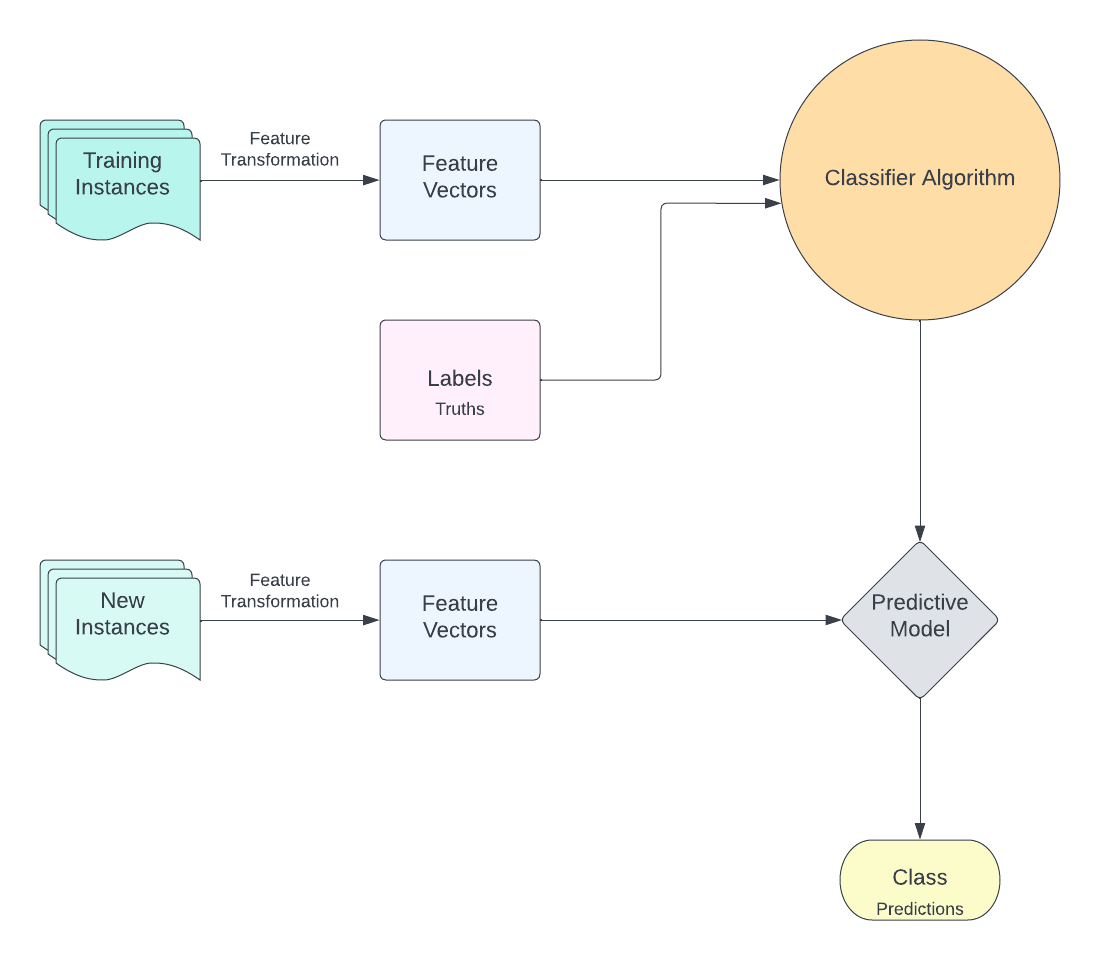

In [82]:
Image("../../data/images/ModellingWorkflow.png")

### Splitting the Raw Data - Hold-out validation

In [83]:
X = df_flights_2.drop('DepDelayClass', axis=1).values# Input features (attributes)
y = df_flights_2['DepDelayClass'].values # Target vector
print('X shape: {}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))

#I will be using the hold-out validation tecnique, i will use 90% of data to train the model, and 10% to test model on new data( i know the answers so i can compare them)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, test_size=0.1, random_state=0)

X shape: (618880, 15)
y shape: (618880,)


In [97]:
df_flights_2.dtypes

Flight_Number         int16
OriginAirportID       int16
DestAirportID         int16
CRSDepTime            int16
DepTime             float16
DepDelayMinutes     float16
TaxiOut             float16
WheelsOn            float16
TaxiIn              float16
CRSArrTime            int16
Cancelled             int16
CRSElapsedTime      float16
AirTime             float16
Distance            float16
TotalAddGTime       float16
DepDelayClass      category
dtype: object

In [100]:
## X = df_flights_2[ml_cols[:-1]]
##y = df_flights_2["DepDelayClass"]

# Encode our target variable
encoder = LabelEncoder().fit(y)
y = encoder.transform(y)

print(X.shape, y.shape)

(618880, 15) (618880,)


In [101]:
df_flights_2.describe()

,Flight_Number,OriginAirportID,DestAirportID,CRSDepTime,DepTime,DepDelayMinutes,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,Cancelled,CRSElapsedTime,AirTime,Distance,TotalAddGTime
count,618880.000000,618880.000000,618880.000000,618880.000000,618880.0,618880.0,618880.0,618880.0,618880.0,618880.000000,618880.000000,618880.0,618880.0,618880.0,618880.0
mean,2685.245550,12676.554528,12679.972887,1329.025208,NaN,NaN,NaN,NaN,NaN,1487.685117,0.019831,NaN,NaN,NaN,NaN
std,1836.070691,1522.442401,1522.248856,487.217304,NaN,NaN,0.0,NaN,0.0,513.897542,0.139419,NaN,NaN,NaN,NaN
min,1.000000,10135.000000,10135.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,-60.0,0.0,16.0,0.0
25%,1103.000000,11292.000000,11292.000000,915.000000,900.0,0.0,11.0,1031.0,4.0,1105.000000,0.000000,88.0,57.0,356.0,0.0
50%,2288.000000,12889.000000,12889.000000,1320.000000,1314.0,0.0,14.0,1448.0,6.0,1515.000000,0.000000,121.0,90.0,628.0,0.0
75%,4231.000000,14057.000000,14057.000000,1733.000000,1737.0,7.0,19.0,1903.0,9.0,1918.000000,0.000000,170.0,138.0,1020.0,0.0
max,9663.000000,16869.000000,16869.000000,2359.000000,2400.0,2692.0,182.0,2400.0,219.0,2400.000000,1.000000,1532.0,686.0,5812.0,375.0


Model Building 
- DecisionTreeClassifier

In [103]:
def get_internal_params(model):
    for attr in dir(model):
        if attr.endswith("_") and not attr.startswith("_"):
            print(attr, getattr(model, attr))

DecisionTreeClassifier

In [105]:
model_DecisionTreeClassifier = DecisionTreeClassifier()
model_DecisionTreeClassifier.fit(X,y)
get_internal_params(model_DecisionTreeClassifier)

classes_ [0 1 2 3 4]
feature_importances_ [2.09049703e-05 9.31894490e-06 3.28431939e-05 3.11974113e-05
 1.53365898e-05 8.87154778e-01 3.18733507e-05 2.26138211e-05
 1.50084543e-05 6.09213577e-06 1.12610332e-01 1.16177373e-05
 1.56340724e-05 2.24495800e-05 0.00000000e+00]
feature_names_in_ ['Flight_Number' 'OriginAirportID' 'DestAirportID' 'CRSDepTime' 'DepTime'
 'DepDelayMinutes' 'TaxiOut' 'WheelsOn' 'TaxiIn' 'CRSArrTime' 'Cancelled'
 'CRSElapsedTime' 'AirTime' 'Distance' 'TotalAddGTime']
max_features_ 15
n_classes_ 5
n_features_ 15
n_features_in_ 15
n_outputs_ 1
tree_ <sklearn.tree._tree.Tree object at 0x000002311D0F2790>


In [106]:
def fit_and_evaluate(X, y, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    start  = time.time() # Start the clock! 
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    kf = KFold(n_splits = 12, shuffle=True)
    
    for train, test in kf.split(X, y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y[train], y[test]
        
        estimator = model(**kwargs) 
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(X, y)

In [107]:
fit_and_evaluate(X, y, DecisionTreeClassifier, "Flight Decision Tree Classifier")

Build and Validation of Flight Decision Tree Classifier took 19.311 seconds
Validation scores are as follows:

precision    0.999919
recall       0.999914
accuracy     0.999914
f1           0.999917
dtype: float64
